In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/AIIP Projet

/content/drive/Shareddrives/AIIP Projet


# Classification

## Manip

In [ ]:
import zipfile

# Spécifiez le nom du fichier zip
zip_file_name = "COVID-CS-Classification-Features.zip"

# Emplacement où vous souhaitez extraire les fichiers (par exemple, "/content/quora-question-pairs")
extraction_path = "/content/drive/Shared drives/AIIP Projet/Classification"

# Exécutez l'extraction
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import os

def create_file_list(directory_path, file_name, output_path):
    # Vérifiez si le chemin du dossier existe
    if not os.path.exists(directory_path):
        return "Le dossier spécifié n'existe pas."

    # Liste des fichiers dans le dossier
    file_list = os.listdir(directory_path)

    # Créez le chemin complet du fichier texte de sortie
    output_file_path = os.path.join(output_path, file_name)

    # Écrivez la liste des noms de fichiers dans le fichier texte
    with open(output_file_path, 'w') as file:
        for file_name in file_list:
            file.write(file_name + '\n')

    return "Fichier texte créé avec succès à l'emplacement : " + output_file_path

In [ ]:
directory_path = "/content/drive/Shareddrives/AIIP Projet/Classification/train/neg"
file_name = "train_NonCOVID.txt"
output_path = "/content/drive/Shareddrives/AIIP Projet/Classification/train"

result = create_file_list(directory_path, file_name, output_path)

In [ ]:
directory_path = "/content/drive/Shareddrives/AIIP Projet/Classification/train/pos"
file_name = "train_COVID.txt"
output_path = "/content/drive/Shareddrives/AIIP Projet/Classification/train"

result = create_file_list(directory_path, file_name, output_path)

In [ ]:
directory_path = "/content/drive/Shareddrives/AIIP Projet/Classification/val/neg"
file_name = "val_NonCOVID.txt"
output_path = "/content/drive/Shareddrives/AIIP Projet/Classification/val"

result = create_file_list(directory_path, file_name, output_path)

In [ ]:
directory_path = "/content/drive/Shareddrives/AIIP Projet/Classification/val/pos"
file_name = "val_COVID.txt"
output_path = "/content/drive/Shareddrives/AIIP Projet/Classification/val"

result = create_file_list(directory_path, file_name, output_path)

In [ ]:
from scipy.io import loadmat

file_path = "/content/drive/Shareddrives/AIIP Projet/Classification/train/pos/88e49efce95bbdd50694bcb645ce7c79_0179.mat"  # Remplacez par le chemin de votre fichier .mat
data = loadmat(file_path)

# Afficher les clés disponibles dans le fichier .mat
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'res2net_feats'])


## Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import tqdm
import os
import math

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

def read_txt(txt_path):
    with open(txt_path) as f:
      lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
  def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
    self.root_dir = root_dir
    self.txt_path = [txt_COVID, txt_NonCOVID]
    self.classes = ["CT_COVID", "CT_NonCOVID"]
    self.num_classes = len(self.classes)
    self.img_list = []
    self.transform = transform

    for c in range(self.num_classes):
      classes_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in read_txt(self.txt_path[c])]
      self.img_list += classes_list

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = self.img_list[idx][0]
    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    sample = {"img": image, "label": int(self.img_list[idx][1])}
    return sample

## Model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import Bottleneck
from torchvision.models.resnet import conv1x1

class Bottle2Neck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, scales=4):
        super(Bottle2Neck, self).__init__()
        width = int(planes * (scales / 32.))
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=scales, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * 4)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Res2Net(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(Res2Net, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], scales=4)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, scales=4)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, scales=4)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, scales=4)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, scales=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, scales))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, scales=scales))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def Res2Net50():
    layers = [3, 4, 6, 3]
    model = Res2Net(Bottle2Neck, layers)
    return model


class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()

        self.res2net = Res2Net50()

        for param in self.res2net.parameters():
            param.requires_grad = False

        num_features = self.res2net.fc.in_features
        self.res2net.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.res2net(x)

## Get

In [ ]:
def get_cost_function():
  return nn.CrossEntropyLoss()

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  return optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

## Train et test

In [ ]:
def train(model, data_loader, optimizer, cost_function, device="cuda"):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  model.train()

  data_loader = tqdm.tqdm(data_loader, total=len(data_loader), unit="batch")

  for batch_idx, batch_samples in enumerate(data_loader):
    inputs, targets = batch_samples["img"].to(device), batch_samples["label"].to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = cost_function(outputs, targets)
    loss.backward()

    optimizer.step()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [ ]:
def test(model, data_loader, cost_function, device="cuda"):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  model.eval()

  with torch.no_grad():
    data_loader = tqdm.tqdm(data_loader, total=len(data_loader), unit="batch")

    for batch_idx, batch_samples in enumerate(data_loader):
      inputs, targets = batch_samples["img"].to(device), batch_samples["label"].to(device)

      outputs = model(inputs)

      loss = cost_function(outputs, targets)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

## Data

In [ ]:
def get_data(batch_size):
  train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomResizedCrop((512), scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.229, 0.224, 0.225])
  ])

  valid_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.229, 0.224, 0.225])
  ])

  path_image = "/content/drive/Shareddrives/AIIP Projet/COVID-CT"
  path_txt_COVID = "/content/drive/Shareddrives/AIIP Projet/Data-split/COVID"
  path_txt_NonCOVID = "/content/drive/Shareddrives/AIIP Projet/Data-split/NonCOVID"

  train_dataset = CovidCTDataset(root_dir=path_image,
                                 txt_COVID=path_txt_COVID + "/trainCT_COVID.txt",
                                 txt_NonCOVID=path_txt_NonCOVID + "/trainCT_NonCOVID.txt",
                                 transform=train_transform)
  valid_dataset = CovidCTDataset(root_dir=path_image,
                                 txt_COVID=path_txt_COVID + "/valCT_COVID.txt",
                                 txt_NonCOVID=path_txt_NonCOVID + "/valCT_NonCOVID.txt",
                                 transform=valid_transform)
  test_dataset = CovidCTDataset(root_dir=path_image,
                                 txt_COVID=path_txt_COVID + "/testCT_COVID.txt",
                                 txt_NonCOVID=path_txt_NonCOVID + "/testCT_NonCOVID.txt",
                                transform=valid_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

  return train_loader, valid_loader, test_loader


## Main

In [ ]:
def main(model, batch_size=128, device="cuda", lr=0.01, wd=0.000001, momentum=0.9, epochs=50):
  train_loader, valid_loader, test_loader = get_data(batch_size)

  optimizer = get_optimizer(model, lr, wd, momentum)

  cost_function = get_cost_function()

  for e in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)
    valid_loss, valid_accuracy = test(model, valid_loader, cost_function, device=device)

  print('After training:')
  train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
  valid_loss, val_accuracy = test(model, valid_loader, cost_function, device=device)
  test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

  print('\n')
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(valid_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  path = "/content/drive/Shareddrives/AIIP Projet/model.pth"
  torch.save(model.state_dict(), path)

### Model3 (model, batch_size=128, device="cuda", lr=0.01, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device)

100%|██████████| 1/1 [00:01<00:00,  1.31s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.19batch/s]



	 Training loss 0.00688, Training accuracy 57.88
	 Validation loss 0.00629, Validation accuracy 71.19
	 Test loss 0.01042, Test accuracy 63.55
-----------------------------------------------------


### Changement de batch_size

#### Model3 (model, batch_size=64, device="cuda", lr=0.01, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, batch_size=64, device=device)

100%|██████████| 2/2 [00:00<00:00,  2.02batch/s]


After training:


100%|██████████| 4/4 [00:01<00:00,  2.18batch/s]



	 Training loss 0.01448, Training accuracy 54.82
	 Validation loss 0.03740, Validation accuracy 37.29
	 Test loss 0.03755, Test accuracy 38.92
-----------------------------------------------------


#### Model3 (model, batch_size=256, device="cuda", lr=0.01, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, batch_size=256, device=device)

100%|██████████| 1/1 [00:01<00:00,  1.01s/batch]


After training:


100%|██████████| 1/1 [00:01<00:00,  1.64s/batch]



	 Training loss 0.00350, Training accuracy 60.94
	 Validation loss 0.01421, Validation accuracy 49.15
	 Test loss 0.00883, Test accuracy 46.31
-----------------------------------------------------


### Changement de lr

#### Model3 (model, batch_size=128, device="cuda", lr=0.001, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.001)

100%|██████████| 1/1 [00:00<00:00,  1.01batch/s]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.15batch/s]



	 Training loss 0.00612, Training accuracy 64.00
	 Validation loss 0.00642, Validation accuracy 47.46
	 Test loss 0.00711, Test accuracy 49.26
-----------------------------------------------------


#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:02<00:00,  2.75s/batch]


After training:


100%|██████████| 2/2 [00:04<00:00,  2.09s/batch]



	 Training loss -0.01372, Training accuracy 60.24
	 Validation loss -0.00329, Validation accuracy 43.22
	 Test loss -0.00031, Test accuracy 48.28
-----------------------------------------------------


#### Model3 (model, batch_size=128, device="cuda", lr=0.00001, wd=0.000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.00001)

100%|██████████| 1/1 [00:01<00:00,  1.02s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.21batch/s]



	 Training loss 0.00651, Training accuracy 53.18
	 Validation loss 0.00729, Validation accuracy 43.22
	 Test loss 0.00878, Test accuracy 45.32
-----------------------------------------------------


### Changement de wd

#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, wd=0.001)

100%|██████████| 1/1 [00:00<00:00,  1.00batch/s]


After training:


100%|██████████| 2/2 [00:02<00:00,  1.02s/batch]



	 Training loss 0.00624, Training accuracy 60.94
	 Validation loss 0.00556, Validation accuracy 64.41
	 Test loss 0.00715, Test accuracy 61.58
-----------------------------------------------------


#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.0000001, momentum=0.9, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, wd=0.0000001)

100%|██████████| 1/1 [00:01<00:00,  1.01s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.08batch/s]



	 Training loss 0.00602, Training accuracy 63.29
	 Validation loss 0.00543, Validation accuracy 59.32
	 Test loss 0.00714, Test accuracy 55.67
-----------------------------------------------------


### Changement de momentum

#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.000001, momentum=0.85, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, momentum=0.85)

100%|██████████| 1/1 [00:00<00:00,  1.01batch/s]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.04batch/s]



	 Training loss 0.00626, Training accuracy 59.06
	 Validation loss 0.00537, Validation accuracy 62.71
	 Test loss 0.00703, Test accuracy 58.62
-----------------------------------------------------


#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.000001, momentum=0.95, epochs=50)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, momentum=0.95)

100%|██████████| 1/1 [00:01<00:00,  1.11s/batch]


After training:


100%|██████████| 2/2 [03:23<00:00, 101.83s/batch]




	 Training loss 0.00621, Training accuracy 55.29
	 Validation loss 0.00596, Validation accuracy 54.24
	 Test loss 0.00753, Test accuracy 54.68
-----------------------------------------------------


### Changement de epoch

#### Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.000001, momentum=0.9, epochs=25)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, epochs=25)

100%|██████████| 1/1 [00:01<00:00,  1.33s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.12batch/s]



	 Training loss 0.00638, Training accuracy 56.24
	 Validation loss 0.00590, Validation accuracy 51.69
	 Test loss 0.00729, Test accuracy 54.19
-----------------------------------------------------


####Model3 (model, batch_size=128, device="cuda", lr=0.0001, wd=0.000001, momentum=0.9, epochs=100)

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001, epochs=100)

100%|██████████| 1/1 [00:01<00:00,  1.31s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.09batch/s]



	 Training loss 0.00606, Training accuracy 62.35
	 Validation loss 0.00630, Validation accuracy 53.39
	 Test loss 0.00769, Test accuracy 60.10
-----------------------------------------------------


### Changement d'optimiseur

#### Adam

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:01<00:00,  1.35s/batch]


After training:


100%|██████████| 2/2 [01:39<00:00, 49.76s/batch]




	 Training loss 0.00615, Training accuracy 57.18
	 Validation loss 0.00590, Validation accuracy 55.08
	 Test loss 0.00761, Test accuracy 50.25
-----------------------------------------------------


#### RMSProp

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:01<00:00,  1.00s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.14batch/s]



	 Training loss 0.00691, Training accuracy 57.41
	 Validation loss 0.00812, Validation accuracy 51.69
	 Test loss 0.00752, Test accuracy 52.71
-----------------------------------------------------


#### Adagrad

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:01<00:00,  1.02s/batch]


After training:


100%|██████████| 2/2 [00:02<00:00,  1.10s/batch]



	 Training loss 0.00603, Training accuracy 62.12
	 Validation loss 0.00571, Validation accuracy 56.78
	 Test loss 0.00674, Test accuracy 59.61
-----------------------------------------------------


#### Adadelta

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:01<00:00,  1.32s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.16batch/s]



	 Training loss 0.00668, Training accuracy 49.18
	 Validation loss 0.00697, Validation accuracy 33.90
	 Test loss 0.00767, Test accuracy 47.78
-----------------------------------------------------


#### Nadam

In [ ]:
model = Model3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, lr=0.0001)

100%|██████████| 1/1 [00:01<00:00,  1.00s/batch]


After training:


100%|██████████| 2/2 [00:01<00:00,  1.19batch/s]



	 Training loss 0.00593, Training accuracy 63.29
	 Validation loss 0.00850, Validation accuracy 53.39
	 Test loss 0.01026, Test accuracy 53.69
-----------------------------------------------------


### Changement de loss function

## Affichage des images

In [ ]:
model = Model3()
model.load_state_dict(torch.load("/content/drive/Shareddrives/AIIP Projet/model.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Model3(
  (res2net): Res2Net(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2Neck(
        (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(8, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

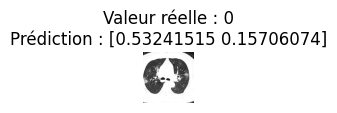

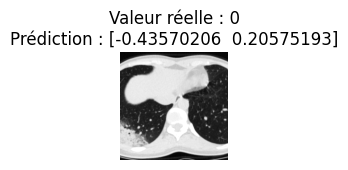

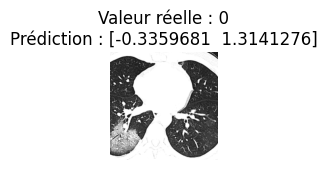

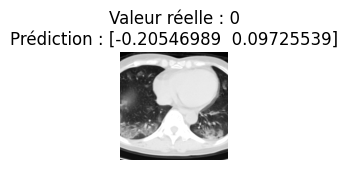

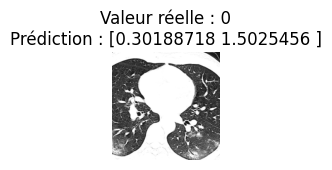

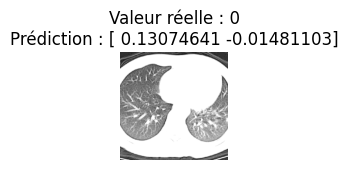

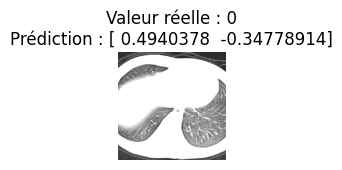

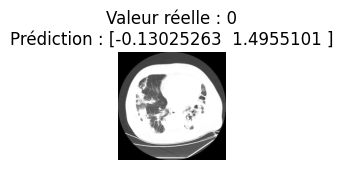

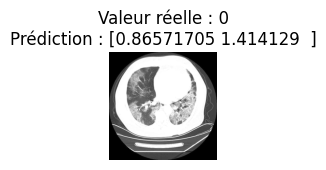

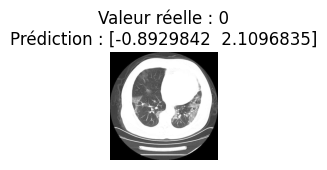

In [ ]:
import matplotlib.pyplot as plt
import torch

# Mettez votre modèle en mode d'évaluation
model.eval()

_, _, test_loader = get_data(batch_size=64)

# Limitez l'affichage aux 10 premières images
max_images = 1

# Itérez sur le jeu de données de test
for batch_idx, batch_samples in enumerate(test_loader):
    # Arrêtez lorsque vous avez affiché les 10 premières images
    if batch_idx >= max_images:
        break

    # Prédictions du modèle
    with torch.no_grad():
        images, labels = batch_samples["img"].to(device), batch_samples["label"].to(device)
        predictions = model(images)

    # Convertissez les tenseurs PyTorch en tableaux NumPy
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Affichez chaque image avec la valeur réelle et la prédiction
    plt.figure(figsize=(3, 4))
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i][0], cmap='gray')  # Supposons que les images sont en niveaux de gris
        plt.title(f"Valeur réelle : {labels[i]}\nPrédiction : {predictions[i]}")
        plt.axis('off')
        plt.show()

# Segmentation

## Importer le dataset

In [ ]:
!apt-get install subversion

^C


In [ ]:
!svn export https://github.com/yuhuan-wu/JCS/trunk/data/COVID-19-CT100

/bin/bash: line 1: svn: command not found


## Traitement des données

In [ ]:
import os

#importer les input images
input_images=os.listdir('/content/drive/Shared drives/AIIP Projet/COVID-19-CT100/tr_im')
input_images=[x for x in input_images if '.png' in x]
input_images.sort()

#importer les target images
target_images=os.listdir('/content/drive/Shared drives/AIIP Projet/COVID-19-CT100/tr_mask_new')
target_images=[x for x in target_images if '.png' in x]
target_images.sort()

for i in range(len(input_images)):
  input_images[i] = '/content/drive/Shared drives/AIIP Projet/COVID-19-CT100/tr_im/'+ input_images[i]

for i in range(len(target_images)):
  target_images[i] = '/content/drive/Shared drives/AIIP Projet/COVID-19-CT100/tr_mask_new/'+ target_images[i]

#Répartie les données en trois (train, validation et test)
train_input_images = input_images[:90]
train_target_images = target_images[:90]
val_input_images = input_images[90:95]
val_target_images = target_images[90:95]
test_input_images = input_images[95:]
test_target_images = target_images[95:]

In [ ]:
import numpy as np
import cv2
import tensorflow as tf

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalisation
    return image

# Fonction de générateur de données personnalisée
def custom_data_generator(input_paths, mask_paths, batch_size=16, target_size=(512, 512)):
    num_samples = len(input_paths)
    while True:
        # Mélanger aléatoirement les indices des échantillons à chaque époque
        indices = np.random.permutation(num_samples)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_input_paths = [input_paths[idx] for idx in batch_indices]
            batch_mask_paths = [mask_paths[idx] for idx in batch_indices]

            batch_inputs = [load_and_preprocess_image(path, target_size) for path in batch_input_paths]
            batch_masks = [load_and_preprocess_image(path, target_size) for path in batch_mask_paths]

            # Convertir en tableaux numpy et ajouter une dimension de canal
            batch_inputs = np.array(batch_inputs)
            batch_inputs = np.expand_dims(batch_inputs, axis=-1)

            batch_masks = np.array(batch_masks)
            batch_masks = np.expand_dims(batch_masks, axis=-1)

            yield batch_inputs, batch_masks

## Model U-net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Création d'un modèle U-Net traditionnel
def unet(input_shape):
    inputs = Input(input_shape)

    # Encodeur
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Couche centrale
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Décodeur
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Couche de sortie
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs, outputs)
    return model

# Configuration du modèle
input_shape = (512, 512, 1)  # Taille de l'image d'entrée
model = unet(input_shape)

# Résumé du modèle
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Entrainement

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Vider la RAM
import tensorflow as tf
tf.keras.backend.clear_session()

# Entraîner le modèle
model.fit(generator, validation_data=val_generator, steps_per_epoch=len(train_input_images) // batch_size,validation_steps = len(val_input_images) // batch_size, epochs=epochs)

Epoch 1/10
90/90 [==============================] - 44s 344ms/step - loss: 21.9915 - accuracy: 0.9263 - val_loss: 0.1946 - val_accuracy: 0.9616
Epoch 2/10
90/90 [==============================] - 30s 335ms/step - loss: 0.3320 - accuracy: 0.9298 - val_loss: 0.1524 - val_accuracy: 0.9675
Epoch 3/10
90/90 [==============================] - 30s 331ms/step - loss: 0.2878 - accuracy: 0.9302 - val_loss: 0.1880 - val_accuracy: 0.9625
Epoch 4/10
90/90 [==============================] - 30s 331ms/step - loss: 0.3772 - accuracy: 0.9300 - val_loss: 0.1713 - val_accuracy: 0.9675
Epoch 5/10
90/90 [==============================] - 30s 329ms/step - loss: 0.3278 - accuracy: 0.9221 - val_loss: 0.1508 - val_accuracy: 0.9658
Epoch 6/10
90/90 [==============================] - 30s 329ms/step - loss: 0.3639 - accuracy: 0.9302 - val_loss: 0.1985 - val_accuracy: 0.9616
Epoch 7/10
90/90 [==============================] - 30s 331ms/step - loss: 0.4261 - accuracy: 0.9302 - val_loss: 0.1875 - val_accuracy: 0.961

In [ ]:
#sauvegarder le modele
model.save('modèles/U-net.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#importer un modele sauvgardé
from tensorflow import keras
model = keras.models.load_model('modèles/U-net.h5')

### Test

Prediction des masks

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_images = [load_and_preprocess_image(path) for path in test_input_images]
test_target = [load_and_preprocess_image(path) for path in test_target_images]

predicted_masks = model.predict(np.array(test_images))

1/1 [==============================] - 8s 8s/step


Calcul de l'intesection over union et le Dice coefficient

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

# Appliquer un seuil de 0.5 pour obtenir une segmentation binaire
threshold = 0.09
binary_predictions = (predicted_masks > threshold).astype(np.uint8)

test_target_flat = np.array(test_target).flatten()
predicted_masks_flat = binary_predictions.flatten()

# Appliquez la métrique IoU (Jaccard)
iou = jaccard_score(test_target_flat, predicted_masks_flat)
print(f'Intersection over Union (IoU): {iou}')

# Calculez l'intersection entre les masques prédits et les masques de vérité terrain
intersection = np.sum(predicted_masks_flat * test_target_flat)

# Calculez la somme des pixels dans les masques prédits et les masques de vérité terrain
sum_pred = np.sum(predicted_masks_flat)
sum_true = np.sum(test_target_flat)

# Calculez le Dice coefficient
dice_coefficient = (2.0 * intersection) / (sum_pred + sum_true)

print(f'Dice Coefficient: {dice_coefficient}')

Intersection over Union (IoU): 0.1523926060999526
Dice Coefficient: 0.2644803607612436


Affichage des images

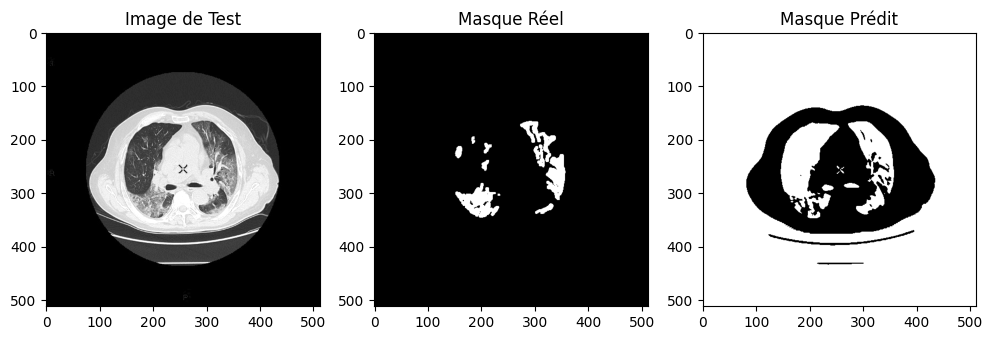

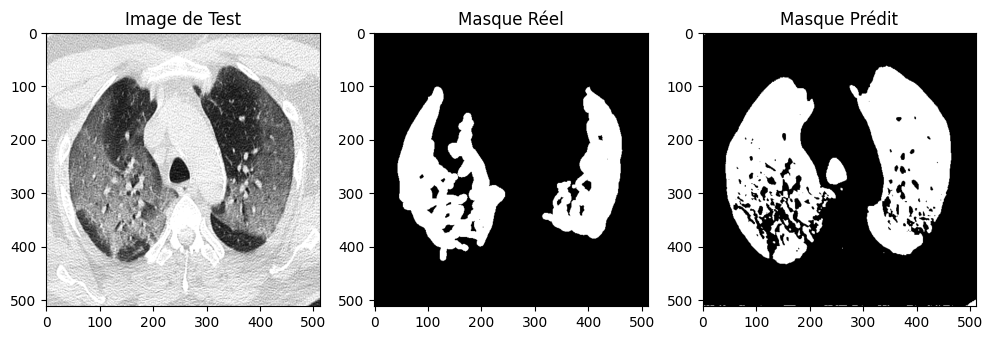

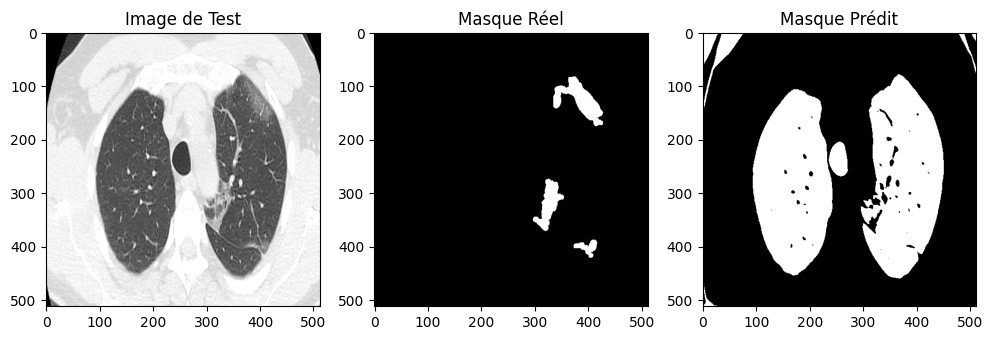

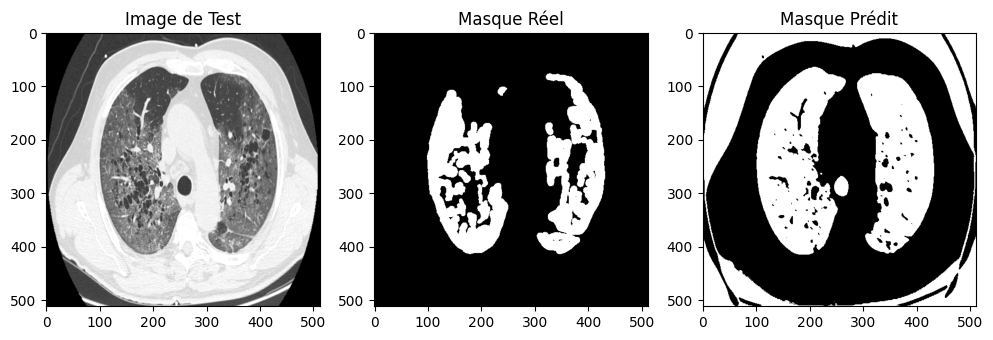

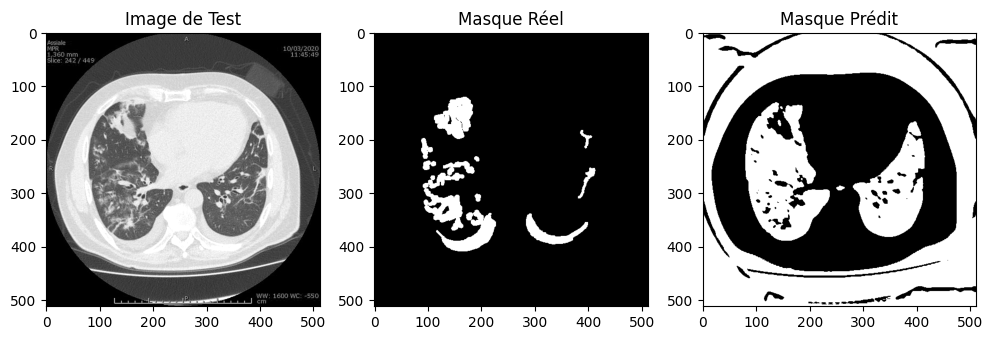

In [ ]:
for i in range(len(test_images)):
    plt.figure(figsize=(12, 4))

    # Image de test
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].reshape(512, 512), cmap='gray')
    plt.title('Image de Test')

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(test_target[i].reshape(512, 512), cmap='gray')
    plt.title('Masque Réel')

    # Masque prédit
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i].reshape(512, 512), cmap='gray')
    plt.title('Masque Prédit')

    plt.show()


## Modèle FCN (Fully convolutional network)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Architecture du FCN
def fcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Middle
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (512, 512, 1)  # Une seule chaîne (niveaux de gris)
num_classes = 1

# Créer le modèle FCN
model = fcn_model(input_shape, num_classes)

# Afficher un résumé du modèle
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 256)     295168

### Entrainement

In [ ]:
from tensorflow import keras

# Définir une fonction pour calculer le Dice coefficient
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

# Enregistrez la métrique personnalisée
keras.utils.get_custom_objects().update({'dice_coefficient': dice_coefficient})

#### changement du batch size

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 5
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

#### Changement du learning rate

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.01

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.0001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

#### Changement du weight decay

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-3
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-5
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

#### Changement des epochs

In [ ]:
#hyperparametres pour l'entrainement
epochs = 20
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 15
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 8
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

#### Changement de l'optimizer

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.SGD(learning_rate=0.01, weight_decay = 1e-4,  momentum=0.9)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
#hyperparametres pour l'entrainement
epochs = 10
batch_size = 1
weight_decay = 1e-4
learning_rate=0.001

# Créer les générateurs de données personnalisés
generator = custom_data_generator(train_input_images, train_target_images, batch_size=batch_size)
val_generator = custom_data_generator(val_input_images, val_target_images, batch_size=batch_size)

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, weight_decay = 1e-4, rho=0.9)

# Compilation du modèle
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coefficient])

#### entrainement

In [ ]:
# Vider la RAM
import tensorflow as tf
tf.keras.backend.clear_session()

# Entraîner le modèle
model.fit(generator, validation_data=val_generator, steps_per_epoch=len(train_input_images) // batch_size, validation_steps = len(val_input_images) // batch_size, epochs=epochs)

Epoch 1/8
90/90 [==============================] - 13s 99ms/step - loss: 0.3306 - dice_coefficient: 0.0730 - val_loss: 0.2062 - val_dice_coefficient: 0.0850
Epoch 2/8
90/90 [==============================] - 9s 99ms/step - loss: 0.2538 - dice_coefficient: 0.0826 - val_loss: 0.1861 - val_dice_coefficient: 0.0804
Epoch 3/8
90/90 [==============================] - 9s 100ms/step - loss: 0.2459 - dice_coefficient: 0.1030 - val_loss: 0.2014 - val_dice_coefficient: 0.1146
Epoch 4/8
90/90 [==============================] - 9s 99ms/step - loss: 0.2059 - dice_coefficient: 0.1542 - val_loss: 0.1821 - val_dice_coefficient: 0.1261
Epoch 5/8
90/90 [==============================] - 9s 101ms/step - loss: 0.1979 - dice_coefficient: 0.1779 - val_loss: 0.1753 - val_dice_coefficient: 0.1507
Epoch 6/8
90/90 [==============================] - 9s 101ms/step - loss: 0.1902 - dice_coefficient: 0.1986 - val_loss: 0.1095 - val_dice_coefficient: 0.2261
Epoch 7/8
90/90 [==============================] - 9s 100ms/

In [ ]:
#sauvegarder le meilleur modele
model.save('modèles/FCN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#importer le modele sauvgardé
from tensorflow import keras
model = keras.models.load_model('modèles/FCN.h5')

### Test

Prediction des masks

In [ ]:
import matplotlib.pyplot as plt

test_images = [load_and_preprocess_image(path) for path in test_input_images]
test_target = [load_and_preprocess_image(path) for path in test_target_images]

predicted_masks = model.predict(np.array(test_images))

1/1 [==============================] - 6s 6s/step


Calcul de l'intesection over union et le Dice coefficient

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

# Appliquer un seuil de 0.5 pour obtenir une segmentation binaire
threshold = 0.5
binary_predictions = (predicted_masks > threshold).astype(np.uint8)

test_target_flat = np.array(test_target).flatten()
predicted_masks_flat = binary_predictions.flatten()

# Appliquez la métrique IoU (Jaccard)
iou = jaccard_score(test_target_flat, predicted_masks_flat)
print(f'Intersection over Union (IoU): {iou}')

# Calculez l'intersection entre les masques prédits et les masques de vérité terrain
intersection = np.sum(predicted_masks_flat * test_target_flat)

# Calculez la somme des pixels dans les masques prédits et les masques de vérité terrain
sum_pred = np.sum(predicted_masks_flat)
sum_true = np.sum(test_target_flat)

# Calculez le Dice coefficient
dice_coefficient = (2.0 * intersection) / (sum_pred + sum_true)

print(f'Dice Coefficient: {dice_coefficient}')

Intersection over Union (IoU): 0.6726370823410042
Dice Coefficient: 0.8042833552387693


Affichage des images

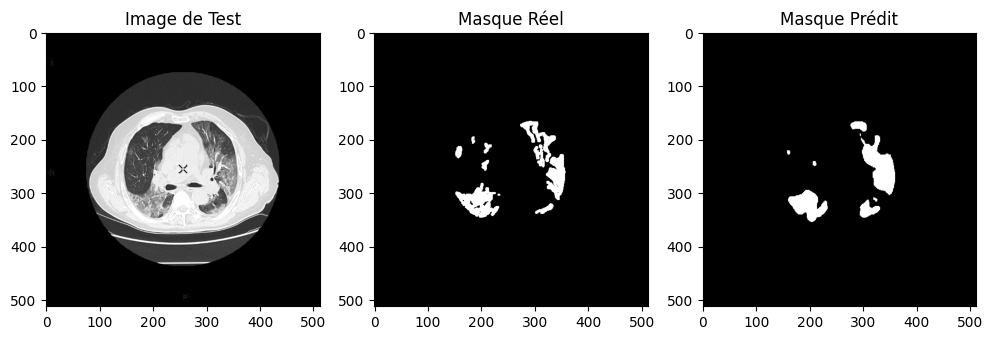

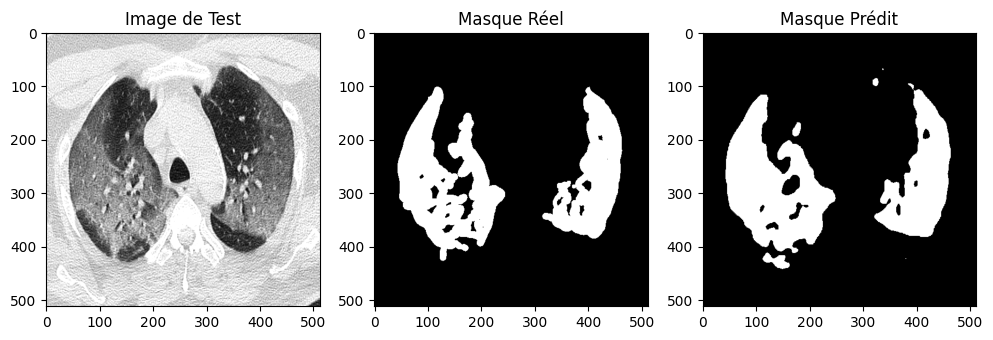

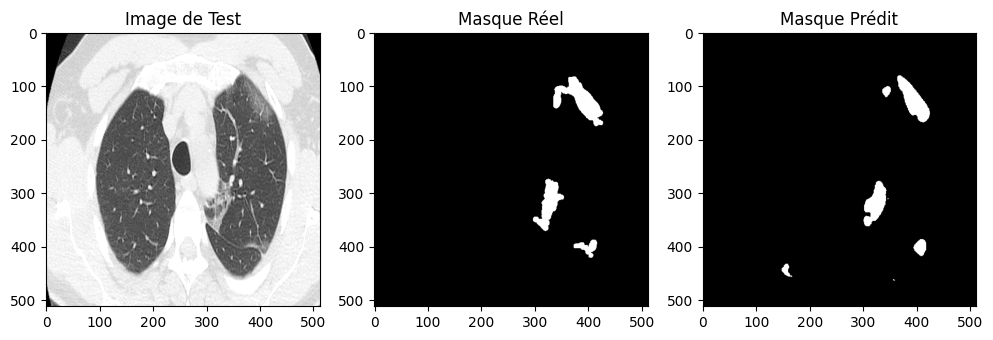

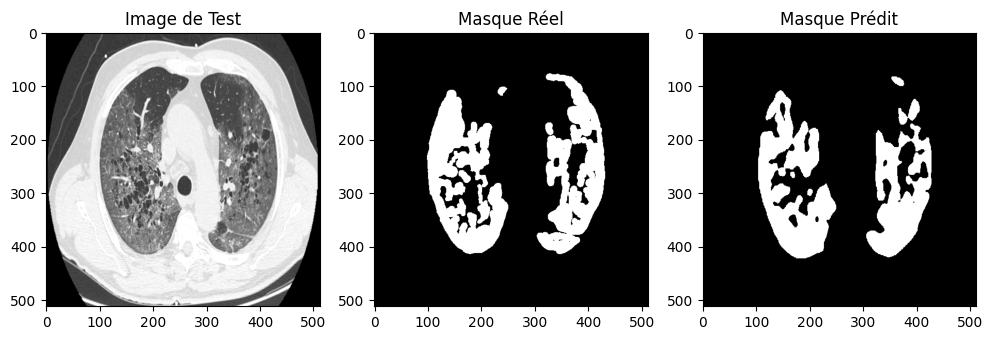

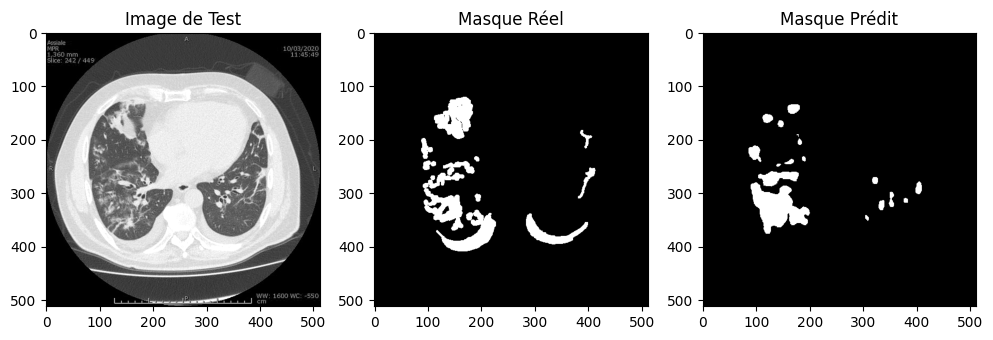

In [ ]:
for i in range(len(test_images)):
    plt.figure(figsize=(12, 4))

    # Image de test
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].reshape(512, 512), cmap='gray')
    plt.title('Image de Test')

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(test_target[i].reshape(512, 512), cmap='gray')
    plt.title('Masque Réel')

    # Masque prédit
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i].reshape(512, 512), cmap='gray')
    plt.title('Masque Prédit')

    plt.show()

# Fusion

## Charger et pretraiter l'image de test

In [ ]:
import cv2
import torch
import numpy as np

image_path = '/content/drive/Shared drives/AIIP Projet/COVID-19-CT100/tr_im/tr_im_0097.png'

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalisation
    return image

#Pretraiter l'image pour l'utiliser lors de la classification
Class_input_image = cv2.imread(image_path)
Class_input_image = Class_input_image.transpose(2, 0, 1)
Class_input_image = torch.from_numpy(Class_input_image)
Class_input_image = Class_input_image.to('cuda:0')
Class_input_image = Class_input_image.to(torch.float32)
Class_input_image = Class_input_image.unsqueeze(0)

#Pretraiter l'image pour l'utiliser lors de la segmentation
Seg_input_image = load_and_preprocess_image(image_path)
Seg_input_image = Seg_input_image.reshape(1, 512, 512, 1)

## Charger les modèles

In [ ]:
#Charger le modèle de classification
model_Classification = Model3()
model_Classification.load_state_dict(torch.load("/content/drive/Shareddrives/AIIP Projet/model.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_Classification.to(device)

Model3(
  (res2net): Res2Net(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2Neck(
        (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(8, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
from tensorflow import keras

# Définir une fonction pour calculer le Dice coefficient
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

# Enregistrez la métrique personnalisée
keras.utils.get_custom_objects().update({'dice_coefficient': dice_coefficient})

# Charger le modèle de segmentation
from tensorflow import keras
model_Segmentation = keras.models.load_model('modèles/FCN.h5')

## Fusion

Les valeurs prédites par le modèle de classification sont : [[10697.118  -6954.3726]] 

Le patient a le Covid

1/1 [==============================] - 0s 21ms/step


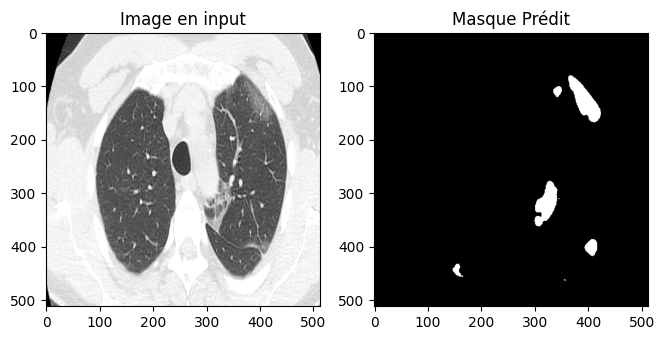

In [ ]:
import matplotlib.pyplot as plt

#Passer le modele de classification en mode evaluation
model_Classification.eval()

#Predir si l'image est une image de poumon infectée ou non
with torch.no_grad():
    prediction = model_Classification(Class_input_image)

predicted_value = prediction.detach().cpu().numpy()

print("Les valeurs prédites par le modèle de classification sont :", predicted_value, "\n")

predicted_value = np.argmax(predicted_value)

#Si le patient a le covid on lance le modèle de segmentation
if predicted_value == 0 :
  print("Le patient a le Covid\n")

  #Prediction du mask
  predicted_mask = model_Segmentation.predict(Seg_input_image)

  #Conversion en un mask binaire
  threshold = 0.5
  binary_prediction = (predicted_mask > threshold).astype(np.uint8)

  #Affichage des images
  plt.figure(figsize=(12, 4))

  # Image de test
  plt.subplot(1, 3, 1)
  plt.imshow(Seg_input_image.reshape(512, 512), cmap='gray')
  plt.title('Image en input')

  # Masque prédit
  plt.subplot(1, 3, 2)
  plt.imshow(binary_prediction.reshape(512, 512), cmap='gray')
  plt.title('Masque Prédit')

  plt.show()

#Sinon on ne lance pas le modèle de segmentation
else :
  print("Le patient n'a pas le Covid")